## Cross Sections ##

This section is testing for the cross section script which looks at wind profiles under 4K warming, 4K cooling, and normal conditons. It also looks at warming and heating "anomolies" which are the deviation of these scenarios from the standard scenario. The script for HPCC use is called month_cross_sections.py and the results of the HPCC run can be found in figures.

In [6]:
# libraries

import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import intake
import dask
import regionmask
import warnings
from pathlib import Path
from tqdm import tqdm
from xmip.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# data

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)

In [64]:
# load some monthly data from the GFDL-CM4 4-K warming experiment

query = dict(experiment_id =['amip', 'amip-p4K', 'amip-m4K'],
             variable_id=['ua', 'va'],
             source_id=['GFDL-CM4'],
             table_id='Amon'
            )

cat = col.search(**query)
print(cat.df['source_id'].unique())

# load data into dictionary
# keys are constructed as 'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

z_kwargs = {'consolidated': True, 'decode_times':True}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing)


['GFDL-CM4']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [69]:
print(dset_dict.keys())

dict_keys(['CFMIP.NOAA-GFDL.GFDL-CM4.amip-p4K.Amon.gr1', 'CFMIP.NOAA-GFDL.GFDL-CM4.amip-m4K.Amon.gr1', 'CMIP.NOAA-GFDL.GFDL-CM4.amip.Amon.gr1'])


In [70]:
dsh = dset_dict['CMIP.NOAA-GFDL.GFDL-CM4.amip.Amon.gr1']
dsw = dset_dict['CFMIP.NOAA-GFDL.GFDL-CM4.amip-p4K.Amon.gr1']
dsc = dset_dict['CFMIP.NOAA-GFDL.GFDL-CM4.amip-m4K.Amon.gr1']

In [74]:
data = dsh.sel(time=dsh.time.dt.month == 6)
data

<xarray.Dataset> Size: 289MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 36, plev: 19,
                     y: 180, x: 288, bnds: 2, vertex: 4)
Coordinates: (12/13)
  * y               (y) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * x               (x) float64 2kB 0.625 1.875 3.125 ... 356.9 358.1 359.4
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
  * time            (time) object 288B 1979-06-16 00:00:00 ... 2014-06-16 00:...
    lat_bounds      (y, bnds, x) float64 829kB dask.array<chunksize=(180, 2, 288), meta=np.ndarray>
    lon_bounds      (x, bnds, y) float64 829kB dask.array<chunksize=(288, 2, 180), meta=np.ndarray>
    ...              ...
    lon             (x, y) float64 415kB 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat             (x, y) float64 415kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
    lon_verticies   (vertex, x, y) float64 2MB dask.array<chunksize=(1, 288, 180), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 2MB dask.array<chunksize=(1, 288, 180), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertex
Data variables:
    ua              (member_id, dcpp_init_year, time, plev, y, x) float32 142MB dask.array<chunksize=(1, 1, 36, 19, 180, 288), meta=np.ndarray>
    va              (member_id, dcpp_init_year, time, plev, y, x) float32 142MB dask.array<chunksize=(1, 1, 33, 19, 180, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    no parent
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.amip.Amon.gr1

In [30]:
# get a couple datasets out of the dictionary

ds = dset_dict['CFMIP.NOAA-GFDL.GFDL-CM4.amip-p4K.Amon.gr1']

In [40]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_data = {}
for i, mon in enumerate(months, start=1):
    data = ds.sel(time=ds.time.dt.month == i)
    monthly_data[mon] = data.mean(dim = 'time')

/var/folders/2h/wmx3j_b939s4yycx33j18njr0000gn/T/ipykernel_47498/1147105126.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar and title


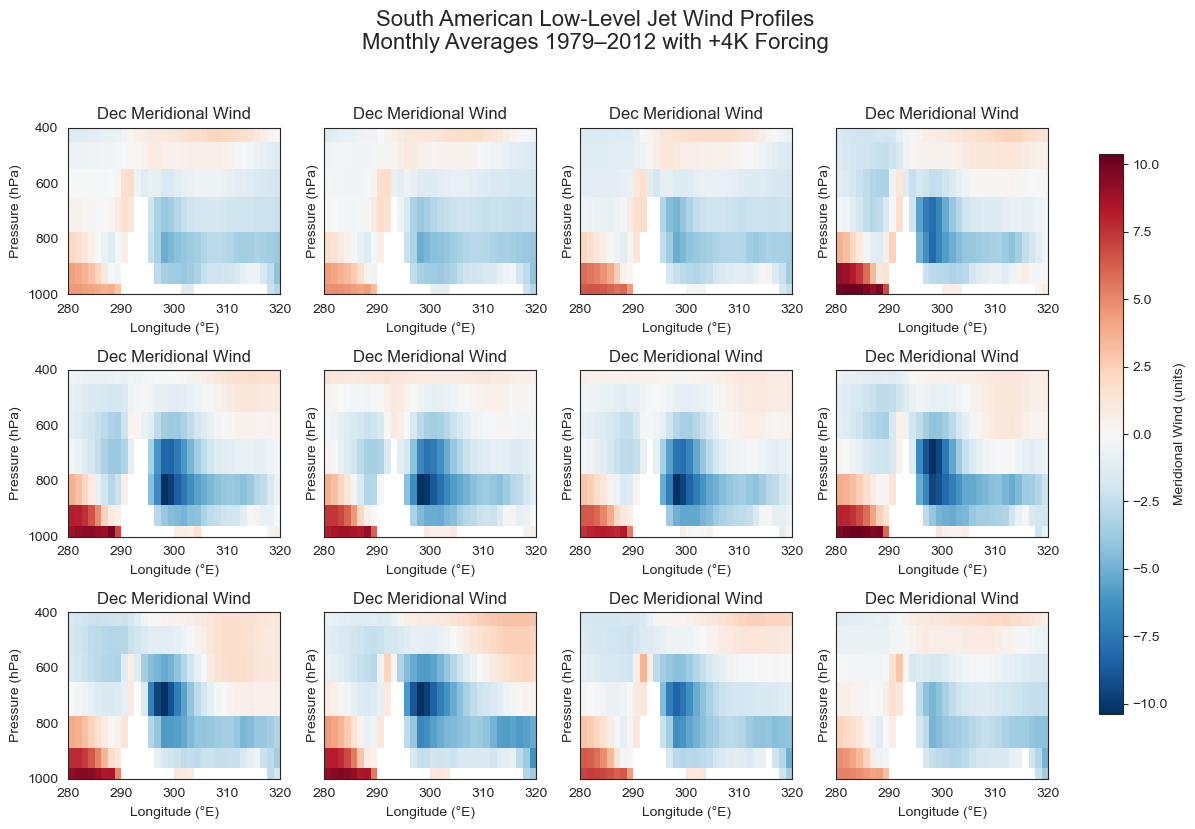

In [ ]:
all_data = ds.va.sel(x=slice(280, 320), y=-20.5)
global_min = all_data.min() # compute global min and max
global_max = all_data.max()

sns.axes_style('dark')
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for ax, mon in zip(axes, months):
    im = monthly_data[mon].va.sel(x=slice(280, 320), y=-20.5).assign_coords(plev=ds['plev'] / 100).plot(ax=ax, add_colorbar=False)
    ax.set_ylim(1000, 400)
    ax.set_title(f'{mon} Meridional Wind')
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Pressure (hPa)')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Average Meridional Wind Speed (m/s)')  # Adjust label as needed

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar and title
plt.savefig('../figures/MonthAverages.png', dpi=300)
plt.show()

## Low Level Jet Detection ##

This second section is for testing of the low level jet detection algorithm used in this paper. It should differentiate between coupled and uncoupled jets.